# AGN Fit - J033226

This notebook demonstrates the options for fitting X-ray-IR AGN models to deep observations of a Type-1 AGN, J033226.49-274035.5, in the Chandra Deep Field South. We'll also see some of the complications that come with trying to fit AGN, especially Type-1s, where sometimes the observations are just outside of the space of our models.

We have pulled the data products from the Chandra Source Catalog for the single deepest observation and produced photometry (in instrumental counts) in 10 energy bands. We caution against using full CSC stacked products without extreme care. The remaining photometry comes from the CANDELS catalogs. Note that the UV-IR photometry and the X-ray observation are not simultaneous.

As we'll see, this AGN falls relatively far from the LR17 $L_{\rm 2 keV} - L_{2500}$ relationship (about 1 dex) and has some other quirks with its SED, which makes it difficult to fit with the narrow range of Eddington ratios allowed by the QSOSED model. We'll thus focus on the more flexible AGN power law model.

## Imports

In [48]:
import numpy as np
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt

from lightning import Lightning
from lightning.priors import UniformPrior, ConstantPrior
plt.style.use('lightning.plots.style.lightning-serif')

## Setup

Fitting the X-ray model necessarily complicates the setup of Lightning, given that we're now potentially dealing with two different kinds of data (fluxes and counts) and an ancilliary response function (ARF).

In [49]:
phot = Table.read('../photometry/J033226_lightning_input.fits', hdu=1)
arf = Table.read('../photometry/J033226.arf', hdu=1)
xray_phot = Table.read('../photometry/J033226_xray_photometry.fits', hdu=1)

print(xray_phot['ENERG_LO', 'ENERG_HI', 'NET_COUNTS', 'NET_COUNTS_UNC'])

     ENERG_LO           ENERG_HI          NET_COUNTS       NET_COUNTS_UNC  
------------------ ------------------ ------------------ ------------------
               0.5 0.5900861491455028 103.16080387669922  17.06914388649152
0.5900861491455028 0.6964033268267372  105.2053121208817  17.39261962324014
0.6964033268267372 0.8218759147586129 159.13980601012312 22.506860760889985
0.8218759147586129 0.9699551872306948 220.28320154820105 28.426639814154843
0.9699551872306948 1.1447142425533319 252.40434296418772 31.560538780349464
1.1447142425533319 1.3509600385206135 252.55886556331126  31.66427014408168
1.3509600385206135  1.594365613560178 259.58237594091764 32.537870928706354
 1.594365613560178 1.8816261304714648 237.50699902462856  30.63509272592005
1.8816261304714648   2.22064303492292  108.6541633292519 19.791982010379417
  2.22064303492292 2.6207413942088964  76.37598680311142  16.38448381206126
2.6207413942088964  3.092926394429888  90.13244771562292   17.0625173963706
 3.092926394

In [50]:
filter_labels = [s.decode().strip() for s in phot['FILTER_LABELS'][0]]
fnu_obs = phot['FNU_OBS'][0]
fnu_unc = phot['FNU_UNC'][0]
redshift = phot['REDSHIFT'][0]
galactic_NH = phot['GALACTIC_NH'][0]

The X-ray "filters" are uniform sensitive boxes constructed ad-hoc: you can supply any number of X-ray bandpasses, with labels formatted like `"XRAY_[LO]_[HI]_[UNIT]"` where `[UNIT]` is any frequency/energy/wavelength unit. Here we use keV.

In [51]:
xray_filter_labels = ['XRAY_%.2f_%.2f_keV' % (elo, ehi) for elo,ehi in zip(xray_phot['ENERG_LO'].data, xray_phot['ENERG_HI'].data)]
xray_counts = xray_phot['NET_COUNTS']
xray_counts_unc = xray_phot['NET_COUNTS_UNC']

We now prepend the X-ray counts to the flux array to construct our full "flux" array:

In [52]:
obs_full = np.zeros(len(xray_filter_labels) + len(filter_labels))
unc_full = np.zeros(len(xray_filter_labels) + len(filter_labels))
exp_full = np.zeros(len(xray_filter_labels) + len(filter_labels))

filter_labels_full = xray_filter_labels + filter_labels
xray_mask = np.array(['XRAY' in s for s in filter_labels_full])
obs_full[xray_mask] = xray_counts
obs_full[~xray_mask] = fnu_obs * 1e3 # IDL Lightning fnu is in Jy, not mJy
unc_full[xray_mask] = xray_counts_unc
unc_full[~xray_mask] = fnu_unc * 1e3 # IDL Lightning fnu is in Jy, not mJy
exp_full[xray_mask] = xray_phot['EXPOSURE']

We display the filter labels and the "flux" and uncertainty arrays here:

In [53]:
t = Table()
t['filter'] = filter_labels_full
t['flux'] = obs_full
t['unc'] = unc_full

ascii.write(t, format='fixed_width_two_line')

            filter                 flux                   unc
------------------ -------------------- ---------------------
XRAY_0.50_0.59_keV   103.16080387669922     17.06914388649152
XRAY_0.59_0.70_keV    105.2053121208817     17.39261962324014
XRAY_0.70_0.82_keV   159.13980601012312    22.506860760889985
XRAY_0.82_0.97_keV   220.28320154820105    28.426639814154843
XRAY_0.97_1.14_keV   252.40434296418772    31.560538780349464
XRAY_1.14_1.35_keV   252.55886556331126     31.66427014408168
XRAY_1.35_1.59_keV   259.58237594091764    32.537870928706354
XRAY_1.59_1.88_keV   237.50699902462856     30.63509272592005
XRAY_1.88_2.22_keV    108.6541633292519    19.791982010379417
XRAY_2.22_2.62_keV    76.37598680311142     16.38448381206126
XRAY_2.62_3.09_keV    90.13244771562292      17.0625173963706
XRAY_3.09_3.65_keV    63.96931056648404    15.393834234535772
XRAY_3.65_4.31_keV    79.15847060425958     17.17091023650916
XRAY_4.31_5.08_keV    63.43539087488492     16.55353507214626
XRAY_5.0

We can see that the X-ray bands have the counts, and the UV-IR bands are fluxes in terms of mJy.

We assemble a wavelength grid to integrate the X-ray models on to make sure that the bandpasses are covered at the redshift of the source:

In [54]:
hc_um = (const.c * const.h).to(u.micron * u.keV).value
lam_05 = hc_um / 0.5
lam_70 = hc_um / 7.0
xray_wave_grid = np.logspace(np.log10(lam_70), np.log10(lam_05), 200) / (1 + redshift)

Note that the wavelength grid must be monotonically increasing.

Now, we're ready to assemble the model - we'll use a power law model first.

In [55]:
lgh = Lightning(filter_labels_full,
                redshift=redshift,
                flux_obs=obs_full,
                flux_obs_unc=unc_full,
                SFH_type='Piecewise-Constant',
                atten_type='Calzetti',
                dust_emission=True,
                agn_emission=True,
                agn_polar_dust=True,
                xray_mode='counts',
                xray_stellar_emission='Stellar-Plaw',
                xray_agn_emission='AGN-Plaw',
                xray_absorption='tbabs',
                xray_wave_grid=xray_wave_grid,
                xray_arf=arf,
                xray_exposure=exp_full,
                galactic_NH=galactic_NH,
                model_unc=0.10,
                print_setup_time=True)

0.033 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
0.551 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.167 s elapsed in dust emission model setup
0.031 s elapsed in agn emission model setup
0.021 s elapsed in X-ray model setup
0.804 s elapsed total


/Users/eqm5663/Research/code/plightning/lightning/get_filters.py:138: RuntimeWarning: invalid value encountered in divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


The warning we see above is telling us that our X-ray bandasses don't overlap with the UV-IR models. That's ok.

## Fit

In [117]:
priors = [UniformPrior([0, 1e3]), # SFH
          UniformPrior([0, 1e3]),
          UniformPrior([0, 1e3]),
          UniformPrior([0, 1e3]),
          UniformPrior([0, 1e3]),
          ConstantPrior([0.020]), # Metallicity
          UniformPrior([0, 5]), # tauV
          ConstantPrior([2]), # alpha
          # ConstantPrior([1]), # Umin
          UniformPrior([0.1, 25]), # Umin
          ConstantPrior([3e5]), # Umax
          UniformPrior([0,1]), # Gamma
          ConstantPrior([0.0047]), #qPAH
          UniformPrior([11, 13]), # log L_AGN
          UniformPrior([0.7, 1]), # cos i - Limited to Type-1 views.
          ConstantPrior([7]), # tau 9.7
          UniformPrior([0,1]), # polar dust tauV
          ConstantPrior([1.8]), # stellar pop. pho. index
          UniformPrior([1.0, 2.5]), # AGN pho. index
          UniformPrior([-1.3, 1.3]), # log deviation from Lusso + Risaliti 2017
          UniformPrior([1, 5e4]) # NH
          ]

Nwalkers = 64

p0s = [pr.sample(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=-1)

Nsteps = 20000
const_dim = np.array([False, False, False, False, False,
                      True,
                      False,
                      True, True, True, False, True,
                      False, False, True, False,
                      True,
                      False, False,
                      False
                      ])

In [118]:
mcmc = lgh.fit(p0,
               method='emcee',
               Nwalkers=Nwalkers,
               Nsteps=Nsteps,
               priors=priors,
               const_dim=const_dim)

/Users/eqm5663/Research/code/plightning/lightning/xray/agn.py:221: RuntimeWarning: divide by zero encountered in log10
  np.log10(lnu_obs) + np.log10(self.specresp) - np.log10(self.phot_energ)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:55<00:00, 30.51it/s]


In [58]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain, logprob_chain, t = lgh.get_mcmc_chains(mcmc,
                                              discard=3000,
                                              thin=500,
                                              Nsamples=500,
                                              const_dim=const_dim,
                                              const_vals=p0[0,const_dim])

MCMC mean acceptance fraction: 0.203
         The autocorrelation estimate may be unreliable.


## Plots

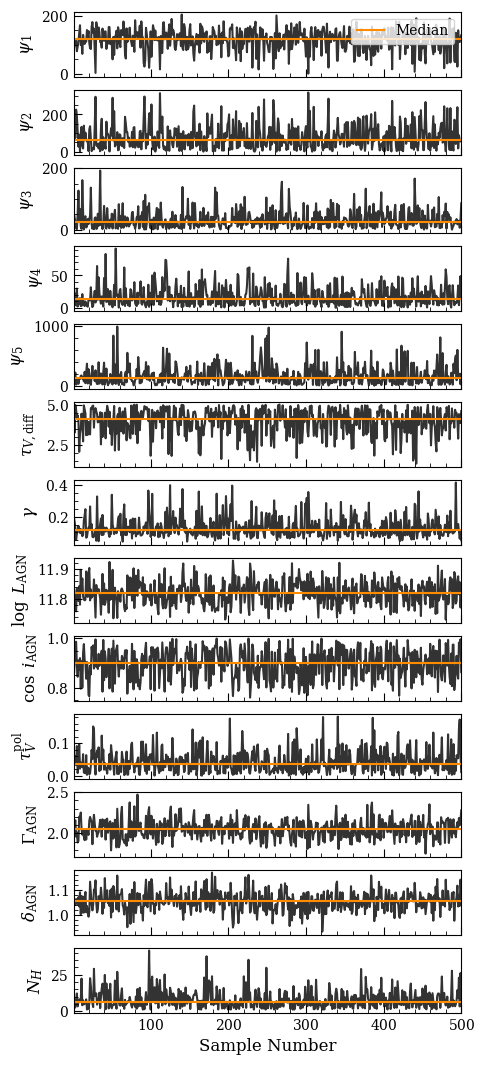

In [59]:
fig, axs = lgh.chain_plot(chain, color='black', alpha=0.8)

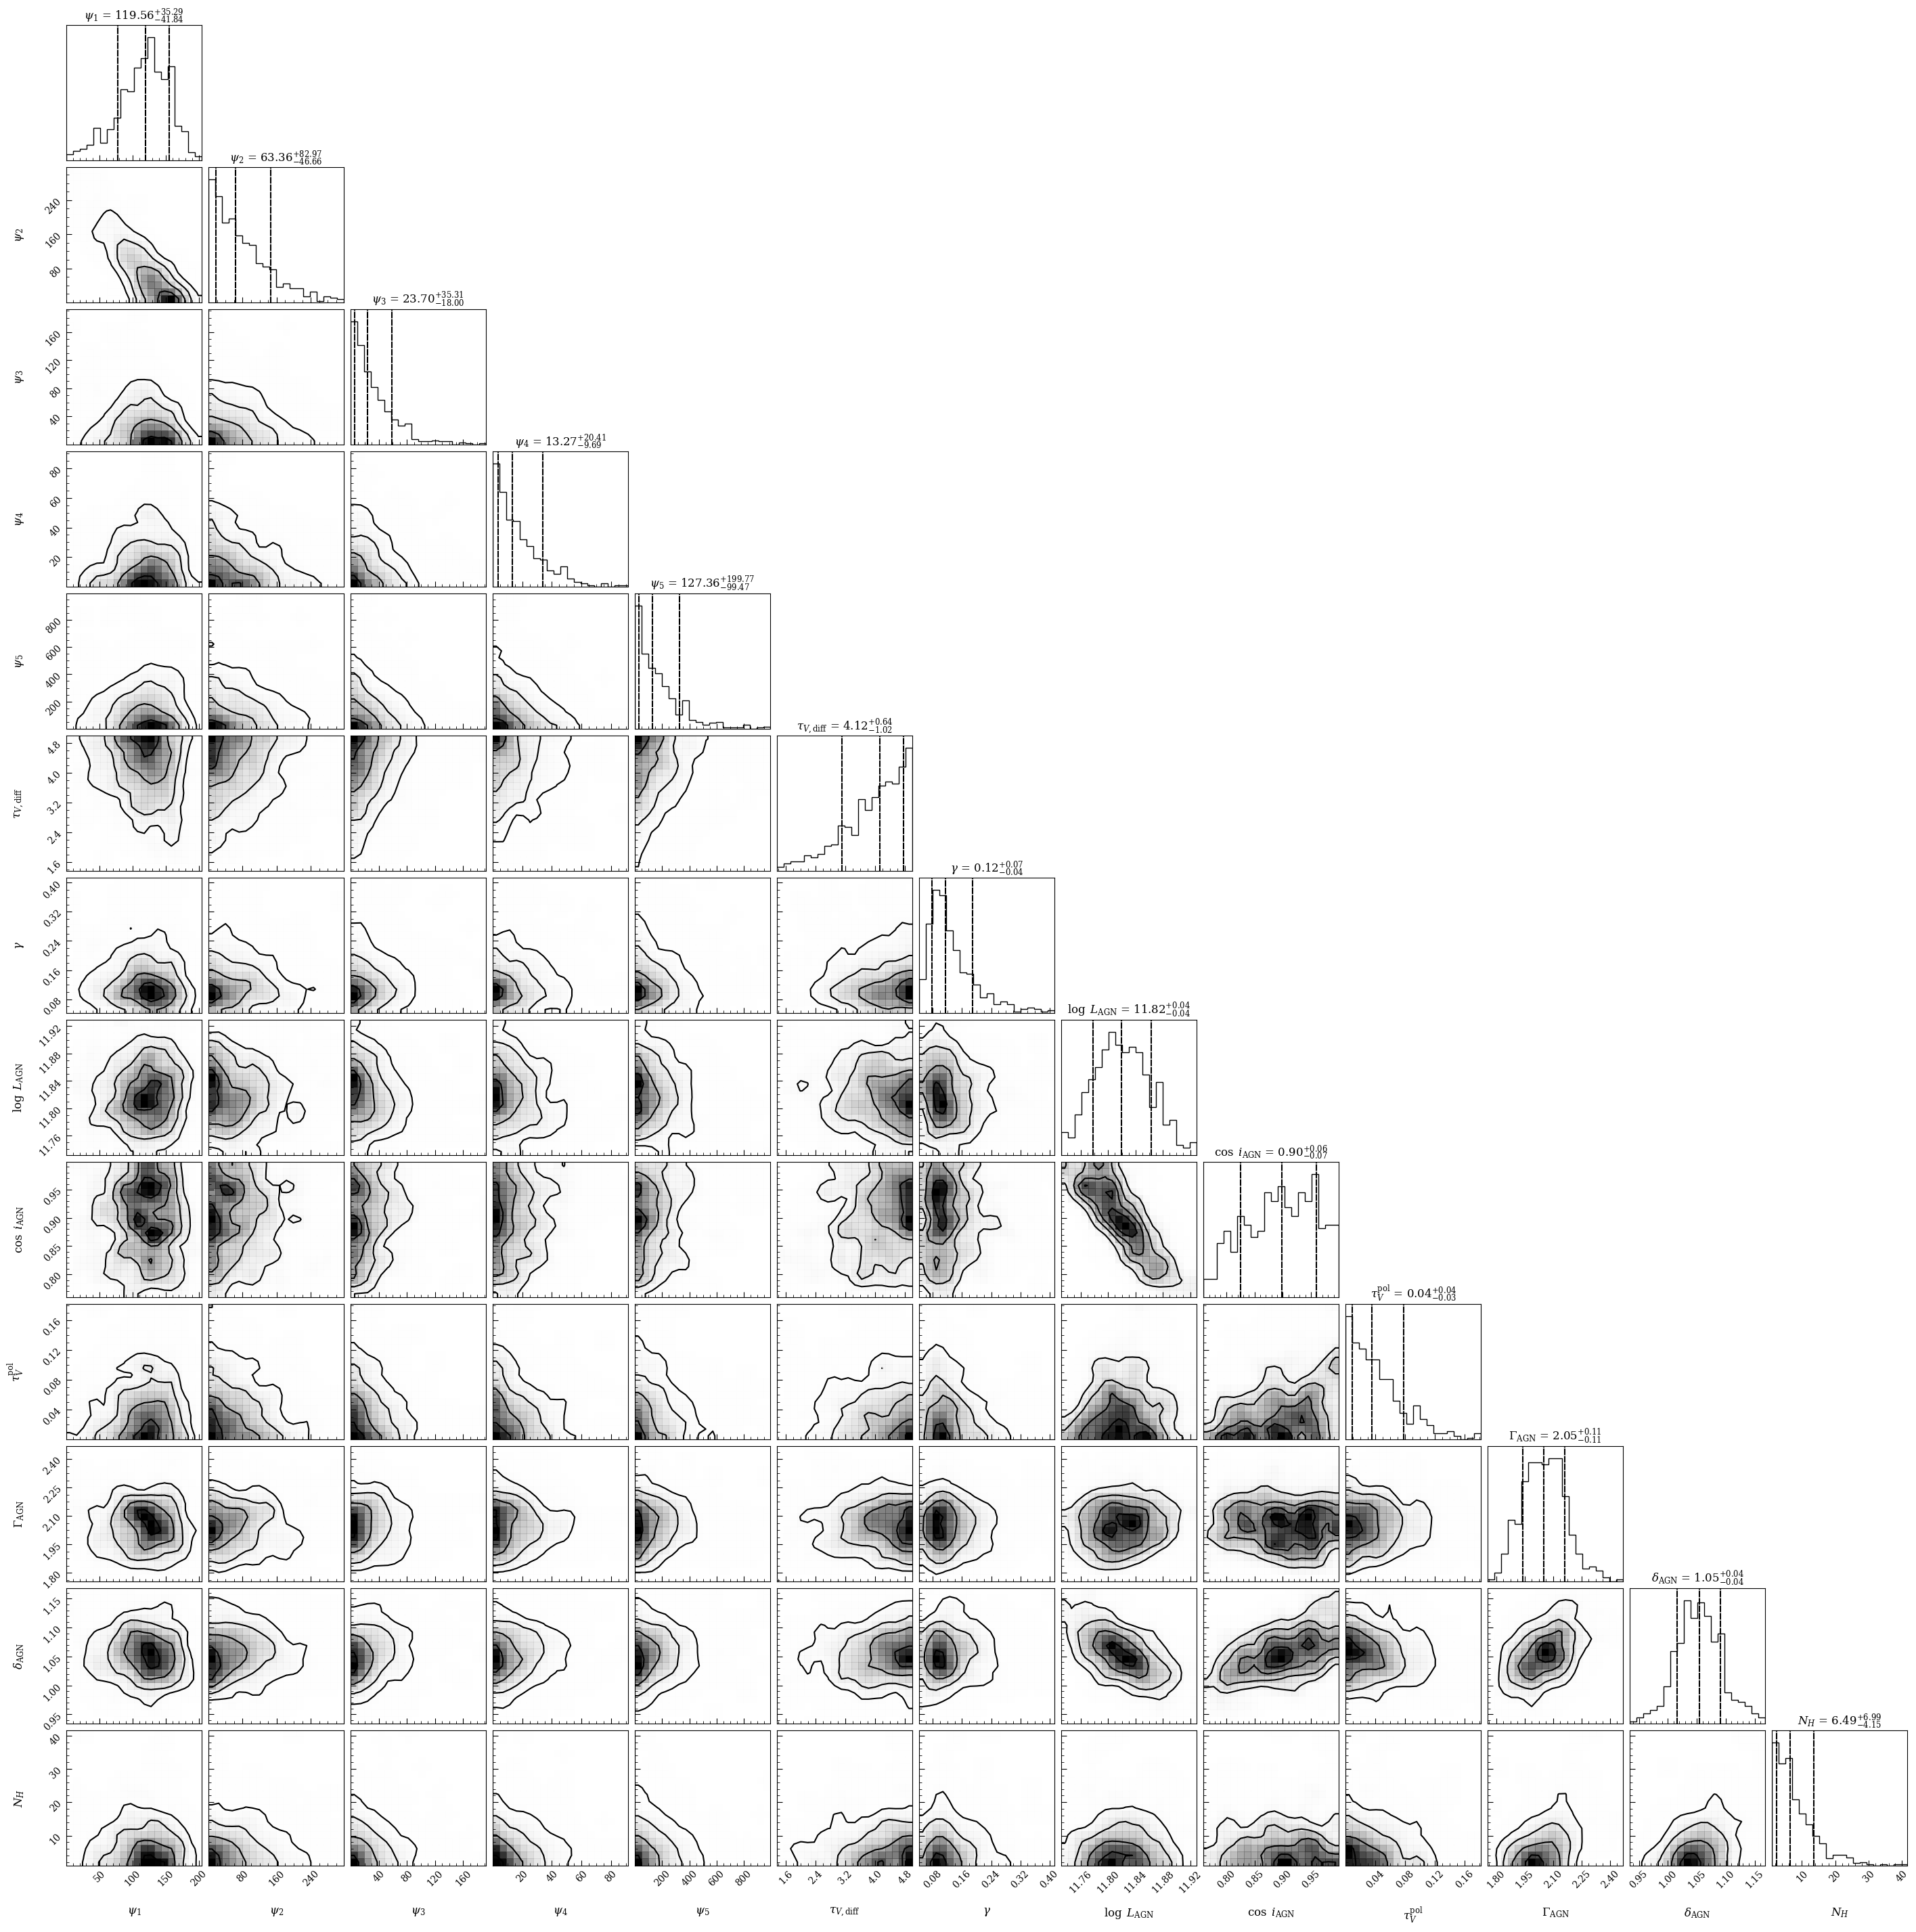

In [60]:
fig = lgh.corner_plot(chain, 
                      quantiles=(0.16, 0.50, 0.84),
                      smooth=1,
                      levels=None,
                      show_titles=True)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


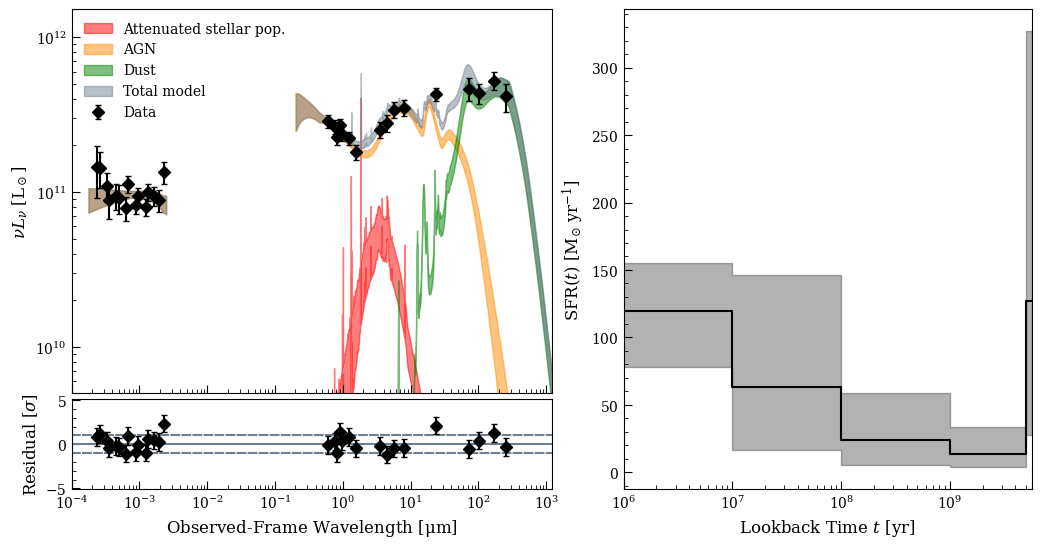

In [119]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'upper left', 'frameon': False})
ax51.set_xticklabels([])
ax51.set_xlim(1e-4, 1200)
ax51.set_ylim(5e9,)
fig5, ax52 = lgh.sed_plot_delchi(chain, logprob_chain, ax=ax52)
ax52.set_xlim(1e-4, 1200)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

Notably, this is a *really* different solution from what we would recover with IDL Lightning and is much closer to the xCIGALE solution. This is down to de-coupling the attenuation of the AGN and the stellar population. If we couple the attenuation of the two (assuming, basically, that we're looking through the galaxy to see the AGN) by disabling the polar dust attenuation, we recover the same solution as IDL Lightning. Both are consistent with the data. Fitting the SED of any Type-1 AGN is its own special nightmare, and this one is so incredibly luminous in the far-IR as to imply a large mass of dust *somewhere*. This model assumes that it's between us and the stars, and not between us and the AGN (supported by broad lines in the spectrum), implying in turn a pretty massive SFR. Be cautious in fitting AGN SEDs, and try (and compare) different models.

We can plot the X-ray portion of the SED in count-rate space, as if we'd fit it in Sherpa or Xspec:

Text(0, 0.5, 'Counts s$^{-1}$ keV$^{-1}$')

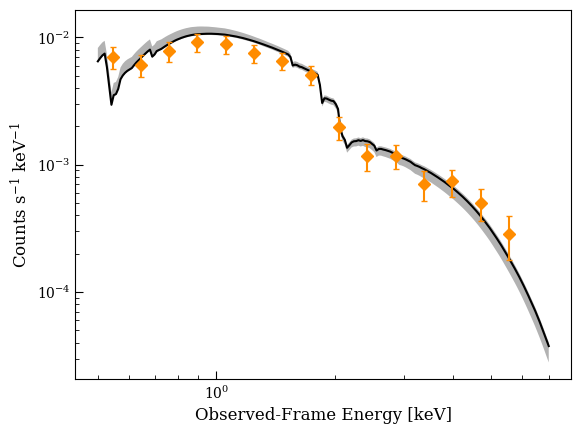

In [116]:
cr = lgh.xray_agn_em.get_model_countrate_hires(chain[:,-3:-1], lgh.agn, chain[:,12:16])

# Put the observations in counts s-1 Hz-1
# print(xray_phot['ENERG_LO', 'ENERG_HI', 'NET_COUNTS', 'NET_COUNTS_UNC'])

dE = xray_phot['ENERG_HI'] - xray_phot['ENERG_LO']
Emid = 0.5 * (xray_phot['ENERG_HI'] + xray_phot['ENERG_LO'])
exposure = lgh.xray_exposure[0]

countrate_obs = xray_phot['NET_COUNTS'] / exposure / dE
countrate_obs_unc = np.sqrt((xray_phot['NET_COUNTS_UNC'] / exposure / dE)**2 + 0.10**2 * countrate_obs**2)

bestfit = np.argmax(logprob_chain)
cr_best = cr[bestfit,:]
cr_lo, cr_hi = np.quantile(cr, q=(0.16, 0.84), axis=0)

fig, ax = plt.subplots()


ax.fill_between(lgh.xray_agn_em.energ_grid_obs,
                lgh.xray_agn_em.nu_grid_obs * cr_lo / lgh.xray_agn_em.energ_grid_obs,
                lgh.xray_agn_em.nu_grid_obs * cr_hi / lgh.xray_agn_em.energ_grid_obs,
                 alpha=0.3)
ax.plot(lgh.xray_agn_em.energ_grid_obs, lgh.xray_agn_em.nu_grid_obs * cr_best / lgh.xray_agn_em.energ_grid_obs)
ax.errorbar(Emid, countrate_obs, yerr=countrate_obs_unc, linestyle='', marker='D', markerfacecolor='darkorange', color='darkorange')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Observed-Frame Energy [keV]')
ax.set_ylabel(r'Counts s$^{-1}$ keV$^{-1}$')

/Users/eqm5663/Research/code/plightning/lightning/ppc.py:77: RuntimeWarning: invalid value encountered in divide
  chi2_rep = np.nansum((Lmod - Lmod_perturbed)**2 / total_unc2, axis=-1)


p (power-law) = 0.61


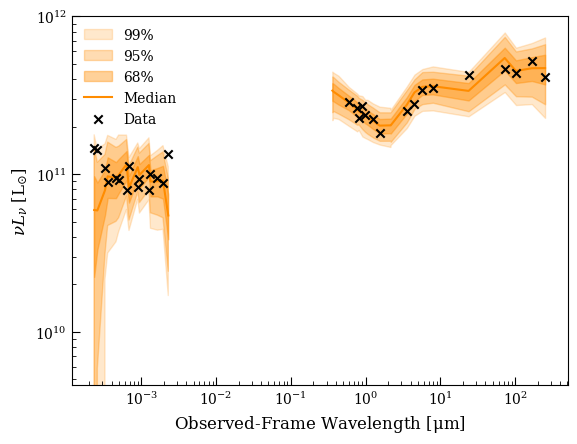

In [62]:
from lightning.ppc import ppc, ppc_sed

pvalue, chi2_rep, chi2_obs = ppc(lgh, chain, logprob_chain)

fig, ax = ppc_sed(lgh, chain, logprob_chain)
ax.legend(loc='upper left')

print('p (power-law) = %.2f' % pvalue)